In [2]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [3]:
import scipy.io
import numpy as np
from itertools import product
from sklearn.neighbors import KNeighborsClassifier

In [4]:
OUT_DIR='/raid0/homes/aghayoor/Desktop/phantom'

In [5]:
def CreateFirstModality(write):
    t1=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t1_arr=sitk.GetArrayFromImage(t1)
    t1_arr[8:65,49:119]=50 # tissue A or c
    t1_arr[65:80,85:119]=50 # tissue A or C
    t1_arr[65:119,8:85]=250 # tissue B
    t1_arr[100:127,65:127]=0
    #
    t1=sitk.GetImageFromArray(t1_arr)
    if write:
        sitk.WriteImage(t1,os.path.join(OUT_DIR,'t1.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t1.mat'), mdict={'t1': t1_arr})
    return t1

def CreatSecondModality(write):
    t2=sitk.Image(128,128,sitk.sitkUInt8)
    #
    t2_arr=sitk.GetArrayFromImage(t2)
    t2_arr[8:65,49:119]=200 # tissue A
    t2_arr[65:119,8:85]=100 # tissue B
    t2_arr[100:127,65:127]=0
    t2_arr[31:80,85:119]=150 # tissue C
    t2_arr[31:53,85:107]=200 # tissue A
    #
    t2=sitk.GetImageFromArray(t2_arr)
    if write:
        sitk.WriteImage(t2,os.path.join(OUT_DIR,'t2.nii.gz'))
        scipy.io.savemat(os.path.join(OUT_DIR,'t2.mat'), mdict={'t2': t2_arr})
    return t2

def DownsampleSecondModality(t2, factor, write):
    t2_lr = sitk.Shrink(t2,[factor,factor])
    if write:
        sitk.WriteImage(t2_lr,os.path.join(OUT_DIR,'t2_lr.nii.gz'))
        t2_lr_arr=sitk.GetArrayFromImage(t2_lr)
        scipy.io.savemat(os.path.join(OUT_DIR,'t2_lr.mat'), mdict={'t2_lr': t2_lr_arr})
    return t2_lr

def CreatePurePlugsMask(t1,t2_lr,write):
    #################
    def isPurePlug(idx, t2_lr, t1):
        hspc=np.array(t2_lr.GetSpacing())
        lspc=np.array(t1.GetSpacing())
        factor=hspc/lspc
        stepSize=1/factor
        hResSize = t1.GetSize()
        # continues index
        cidx=np.array([float(i) for i in idx])
        #print('----------------------------')
        #print("index: {0}".format(cidx)) # <-----
        p = t2_lr.TransformContinuousIndexToPhysicalPoint(cidx)
        #print(p)
        #
        isInside = True
        t1_sampleValues=[]
        for iss in np.arange(cidx[0]-1.0/2+stepSize[0]/2,cidx[0]+1.0/2,stepSize[0]):
            for jss in np.arange(cidx[1]-1.0/2+stepSize[1]/2,cidx[1]+1.0/2,stepSize[1]):
                cssidx=[iss, jss]
                #
                #print("continus subsample: {0}".format(cssidx)) # <-----
                #
                p = t2_lr.TransformContinuousIndexToPhysicalPoint(cssidx)
                #
                #print("point: {0}".format(p)) # <-----
                #
                newidx = t1.TransformPhysicalPointToIndex(p)
                #
                #print("newidx: {0}".format(newidx)) # <-----
                #
                if any( newidx[i] < 0 or newidx[i] >= hResSize[i] for i in range(len(newidx))):
                    isInside = False
                    #
                    #print("is not inside") # <-----
                    #
                    break
                else:
                    t1_value = t1[newidx]
                    t1_sampleValues.append(t1_value)
            else:
                continue
            break

        ispure = False
        if isInside:
            #
            #print("sample values: ") # <-----
            #print(t1_sampleValues) # <-----
            #
            t1_arr = np.array(t1_sampleValues)
            # check to see wether the variance is zero
            # In this case, surely we have a pure plug
            var_t1 = np.var(t1_arr)
            #
            #print("var: {0}".format(var_t1)) # <-----
            #
            if var_t1 == 0: # it means that the std in at least one image is zero 
                ispure = True
            else:
                ispure = False
        #
        #print("Is pure: {0}".format(ispure)) # <-----
        #
        return ispure
    #################
    purePlugsMask = sitk.Image(t2_lr.GetSize(),sitk.sitkUInt8)
    purePlugsMask.CopyInformation(t2_lr)
    t2_lr_size = t2_lr.GetSize()
    for i in range(0,t2_lr_size[0]):
          for j in range(0,t2_lr_size[1]):
                idx=[i,j]
                if( isPurePlug(idx,t2_lr,t1) ):
                    purePlugsMask[idx] = 1
                else:
                    purePlugsMask[idx] = 0
    if write:
        sitk.WriteImage(purePlugsMask,os.path.join(OUT_DIR,'pureplugs_mask.nii.gz'))
    return purePlugsMask

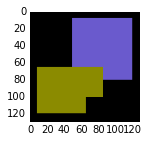

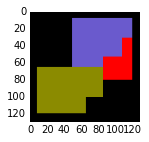

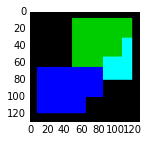

In [7]:
t1=CreateFirstModality(False)
t2=CreatSecondModality(False)
myshow(sitk.LabelToRGB(t1))
myshow(sitk.LabelToRGB(t2))
#
# segemntation baseline
seg_mask=(t2==200)*1+(t2==150)*3+(t2==100)*2
myshow(sitk.LabelToRGB(seg_mask))

In [8]:
#
#
# KNN
#
#

In [29]:
def CreateTrainingSamples(t1,t2_lr,sample_num):
    trainSampleSet=[]
    trainLabels=[]
    count_b=0; count_1=0; count_2=0; count_3=0
    while( count_b < sample_num or count_1 < sample_num or count_2 < sample_num or count_3 < sample_num):
        index = np.random.randint(t1.GetSize()[0],size=(1,2))
        idx = [index[0,0].item(),index[0,1].item()]
        t1_value = t1[idx]
        p = t1.TransformIndexToPhysicalPoint(idx)
        t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
        if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
            continue
        t2_lr_value = t2_lr[t2_lr_idx]
        if (t2_lr_value == 0):
            if count_b >= sample_num:
                continue
            label=0
            count_b += 1
        elif (t2_lr_value == 200):
            if count_1 >= sample_num:
                continue
            label=1
            count_1 += 1
        elif (t2_lr_value == 100):
            if count_2 >= sample_num:
                continue
            label=2
            count_2 += 1
        elif (t2_lr_value == 150):
            if count_3 >= sample_num:
                continue
            label=3
            count_3 += 1
        else:
            raise ValueError('ERROR!!! invalid lable {0}'.format(t2_lr_value))
        trainSampleSet.append([t1_value,t2_lr_value])
        trainLabels.append(label)
    print(count_b)
    print(count_1)
    print(count_2)
    print(count_3)
    return trainSampleSet, trainLabels

def RunKNN(t1,t2_lr,sample_num):
    n_neighbors=15
    weights='distance'
    algorithm='kd_tree'
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    #
    trainSampleSet, trainLabels = CreateTrainingSamples(t1,t2_lr,sample_num)
    neigh.fit(trainSampleSet, trainLabels)
    #
    out_seg = sitk.Image(t1.GetSize(),sitk.sitkUInt8)
    for i in range(0,t1.GetSize()[0]):
        for j in range(0,t1.GetSize()[1]):
            idx=[i,j]
            t1_value=t1[idx]
            p = t1.TransformIndexToPhysicalPoint(idx)
            t2_lr_idx = t2_lr.TransformPhysicalPointToIndex(p)
            if any( t2_lr_idx[i] < 0 or t2_lr_idx[i] >= t2_lr.GetSize()[i] for i in range(len(t2_lr_idx))):
                out_seg[idx]=0
                continue
            t2_lr_value = t2_lr[t2_lr_idx]
            testSample = [[t1_value,t2_lr_value]]
            out_seg[idx] = neigh.predict(testSample).item()
    return out_seg

(25, 25)
(5.0, 5.0)


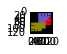

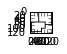

In [30]:
# downsampling and pureplugs mask
dfactor = 5 # downsampling factro
t2_lr = DownsampleSecondModality(t2, dfactor, False)
myshow(sitk.LabelToRGB(t2_lr))
print(t2_lr.GetSize())
print(t2_lr.GetSpacing())
#
purePlugsMask = CreatePurePlugsMask(t1,t2_lr,False)
myshow(purePlugsMask)

40
40
40
40
1050.0


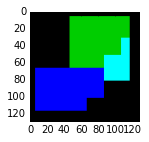

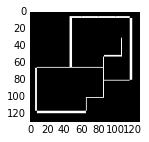

In [36]:
out_seg = RunKNN(t1,t2_lr,40)
myshow(sitk.LabelToRGB(out_seg))

diff=abs(seg_mask-out_seg)>0
myshow(diff)

stats=sitk.StatisticsImageFilter()
stats.Execute(diff)
print(stats.GetSum())